<font size=6>Automatic tagging of questions  
Part 1 : Data Exploration</font>



---

**Checking environment**

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
# PATH_DRIVE : to change according to your Google Drive folders
PATH_DRIVE = "/content/drive/My Drive/MachineLearning/ML05"

In [ ]:
if IN_COLAB:
    print("Le notebook est exécuté sur Google Colab")
else:
    print("Le notebook est exécuté en local")

Le notebook est exécuté sur Google Colab


In [ ]:
if IN_COLAB:
    from google.colab import drive, files
    drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


---

<font size=5>**Table of contents**</font>

[1. Data cleaning](#1_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1. Loading the data](#1_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2. Cleaning the body of the questions](#1_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3. Cleaning the tags](#1_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4. Applying the changes](#1_4)  
  
[2. Data exploration](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Tags](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Body of questions](#2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3. Title of questions](#2_3)  
  
[3. Data preparation](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Preparation of the multi-label targets](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Stratified data splits](#3_2)  

---
## <font color=blue>Notebook set-up</font>

**Libraries importation**

In [ ]:
if IN_COLAB:
    !pip install scikit-multilearn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
if IN_COLAB:
  nltk.download('stopwords')
  nltk.download('wordnet')
  nltk.download('punkt')
  import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from bs4 import BeautifulSoup
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

In [ ]:
if IN_COLAB:
    sys.path.append(PATH_DRIVE)
    os.chdir(PATH_DRIVE)
    import sf_graphiques as sfg
else:
    import modules_perso.sf_graphiques as sfg

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Notebook set-up**

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    if IN_COLAB:
        path = PATH_DRIVE + "/" + path
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution)

---
<a id='1_0'></a>

## <font color=blue>1. Data cleaning</font>

### 1.1. Loading the data

I load data from the 10 .csv files. Each one includes 50,000 questions (body and title) and their associated tags. I concatenate them in one dataframe.

In [ ]:
raw_data = pd.DataFrame()
for i in range(1, 11):
    filename = "QueryResults{:02d}.csv".format(i)
#    data.append(pd.read_csv(filename, index_col=0))
    raw_data = pd.concat([raw_data, pd.read_csv(filename, index_col=0)])

In [ ]:
raw_data.shape

(500000, 5)

In [ ]:
raw_data.head()

,Body,Title,Tags,Score,ViewCount
Id,,,,,
11227809,<p>Here is a piece of C++ code that shows some...,Why is processing a sorted array faster than p...,<java><c++><performance><optimization><branch-...,24614,1507436.0
927358,<p>I accidentally committed the wrong files to...,How do I undo the most recent local commits in...,<git><version-control><git-commit><undo><pre-c...,21252,8720682.0
2003505,<p>I want to delete a branch both locally and ...,How do I delete a Git branch locally and remot...,<git><version-control><git-branch><git-push><g...,17094,8265890.0
292357,<p>What are the differences between <code>git ...,What is the difference between 'git pull' and ...,<git><version-control><git-pull><git-fetch>,12013,2820674.0
231767,<p>What is the use of the <code>yield</code> k...,"What does the ""yield"" keyword do?",<python><iterator><generator><yield><coroutine>,10331,2258880.0


I have 500,000 lines, as expected.  
I must remove html tags from the Body column, to keep only the text. To do so, I use BeautifulSoup.  
I also have to change the format of the Tags column, to get a list of tags.

<a id="1_2"></a>

### 1.2. Cleaning the body of the questions

I have a deeper look at the Body column, with the first line as example.

In [ ]:
raw_data.iloc[0].Body

'<p>Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data miraculously makes the code almost six times faster:</p>\n<pre class="lang-cpp prettyprint-override"><code>#include &lt;algorithm&gt;\n#include &lt;ctime&gt;\n#include &lt;iostream&gt;\n\nint main()\n{\n    // Generate data\n    const unsigned arraySize = 32768;\n    int data[arraySize];\n\n    for (unsigned c = 0; c &lt; arraySize; ++c)\n        data[c] = std::rand() % 256;\n\n    // !!! With this, the next loop runs faster.\n    std::sort(data, data + arraySize);\n\n    // Test\n    clock_t start = clock();\n    long long sum = 0;\n\n    for (unsigned i = 0; i &lt; 100000; ++i)\n    {\n        // Primary loop\n        for (unsigned c = 0; c &lt; arraySize; ++c)\n        {\n            if (data[c] &gt;= 128)\n                sum += data[c];\n        }\n    }\n\n    double elapsedTime = static_cast&lt;double&gt;(clock() - start) / CLOCKS_PER_SEC;\n\n    std::cout &lt;&lt; e

3-steps process on the Body column :
- remove all programming code (within 'code' html tags) ;
- get text without html tags ;
- replace every '\n' by a space.

In [ ]:
essai = BeautifulSoup(raw_data.iloc[0].Body)
for code_to_remove in essai.find_all("code"):
    code_to_remove.decompose()

In [ ]:
essai.get_text().replace("\n", " ")

'Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data miraculously makes the code almost six times faster:   Without , the code runs in 11.54 seconds. With the sorted data, the code runs in 1.93 seconds.   Initially, I thought this might be just a language or compiler anomaly, so I tried Java:  With a similar but less extreme result.  My first thought was that sorting brings the data into the cache, but then I thought how silly that was because the array was just generated.  What is going on? Why is processing a sorted array faster than processing an unsorted array?  The code is summing up some independent terms, so the order should not matter. '

In [ ]:
def clean_body(html_text):
    text_to_transform = BeautifulSoup(html_text)
    for code_to_remove in text_to_transform.find_all("code"):
        code_to_remove.decompose()
    return text_to_transform.get_text().replace("\n", " ")

<a id="1_3"></a>

### 1.3. Cleaning the tags

I now take a deeper look at the Tags column.

In [ ]:
raw_data.iloc[0].Tags

'<java><c++><performance><optimization><branch-prediction>'

I need to transform those tags in a list of text tags. I will apply a binary CountVectorizer to get a table of labels as the target of the multilabel classifier.  
I must be careful with side effects : 
- tags beginning with a dot or a number are not correctly incorporated. So I add either "dot" or "n" between "<" and "." or the number. 
- when there is only one tag, there are no tags symbols "<" and ">", so I need to add them.

In [ ]:
essai = BeautifulSoup(raw_data.iloc[0].Tags, "html.parser")

In [ ]:
[tag.name for tag in essai.find_all()]

['java', 'c++', 'performance', 'optimization', 'branch-prediction']

In [ ]:
def clean_tags(tags_text, regex_deb, regex_fin, regex_number):
    tags_text = tags_text.replace("<.", "<dot.")
    tags_text = regex_deb.sub("<", tags_text)
    tags_text = regex_fin.sub(">", tags_text)
    tags_text = regex_number.sub(r"\1n\2", tags_text)
    tags_to_transform = BeautifulSoup(tags_text, "html.parser")
    return [tag.name for tag in tags_to_transform.find_all()]

<a id="1_4"></a>

### 1.4. Applying the changes

In [ ]:
regex_deb_tags = re.compile("^[^<]")
regex_fin_tags = re.compile("[^>]$")
regex_number_tags = re.compile(r"^(<)([0-9])")
data = raw_data[["Body","Title","Tags"]].copy()
for idx, row in data.iterrows():
    data.loc[idx, "Body"] = clean_body(row.Body)
    data.loc[idx, "Tags"] = clean_tags(row.Tags, regex_deb_tags, 
                                       regex_fin_tags, regex_number_tags)
data.head()

,Body,Title,Tags
Id,,,
11227809,Here is a piece of C++ code that shows some ve...,Why is processing a sorted array faster than p...,"[java, c++, performance, optimization, branch-..."
927358,I accidentally committed the wrong files to Gi...,How do I undo the most recent local commits in...,"[git, version-control, git-commit, undo, pre-c..."
2003505,I want to delete a branch both locally and rem...,How do I delete a Git branch locally and remot...,"[git, version-control, git-branch, git-push, g..."
292357,What are the differences between and ?,What is the difference between 'git pull' and ...,"[git, version-control, git-pull, git-fetch]"
231767,"What is the use of the keyword in Python, and...","What does the ""yield"" keyword do?","[python, iterator, generator, yield, coroutine]"


Data are ready for exploration

---
<a id='2_0'></a>

## <font color=blue>2. Data exploration</font>

### 2.1. Tags

In [ ]:
freq_tags = defaultdict(int)
nb_tags = defaultdict(int)
for lin, tags in data.Tags.items():
    nb_tags[len(tags)] += 1
    for tag in tags:
        freq_tags[tag] += 1

#### 2.1.1. Number of tags by question

In [ ]:
data_graph = pd.Series(nb_tags)
data_graph

5     71403
4    106802
3    146790
2    125554
1     49449
6         2
dtype: int64

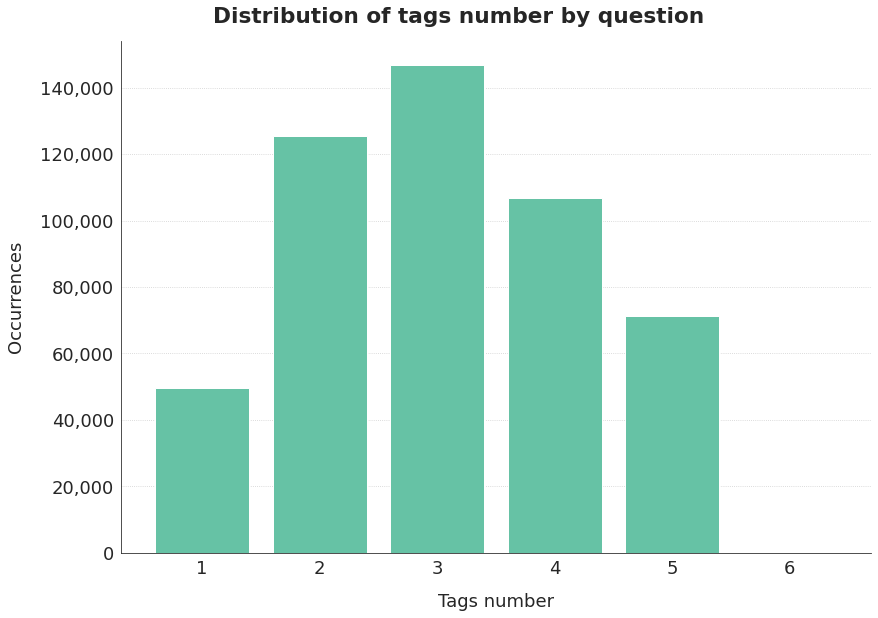

In [ ]:
graph = sfg.MyGraph("Distribution of tags number by question")
graph.add_barv(data_graph.index, data_graph)
graph.set_axe_x(label="Tags number")
graph.set_axe_y(label="Occurrences", tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
plt.show()

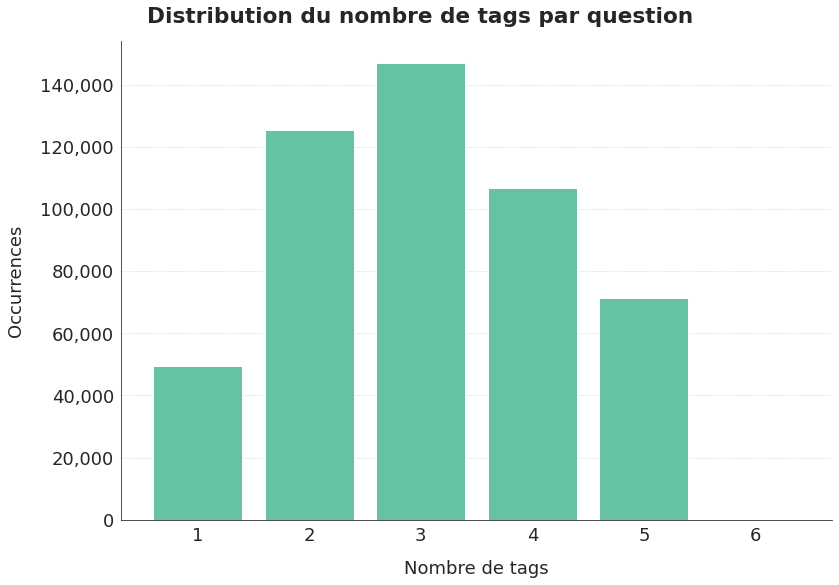

In [ ]:
graph = sfg.MyGraph("Distribution du nombre de tags par question")
graph.add_barv(data_graph.index, data_graph)
graph.set_axe_x(label="Nombre de tags")
graph.set_axe_y(label="Occurrences", tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
save_fig("ml05_01_nb_tags_question")
plt.show()

Most of questions have 3, 2 or 4 tags.  
Maximum number of tags is 6. Only 2 questions have 6 tags.

#### 2.1.2. Most frequent tags

In [ ]:
data_graph = pd.Series(freq_tags).sort_values(ascending=False)
data_graph.describe()

count    28097.000000
mean        54.282023
std        677.501670
min          1.000000
25%          1.000000
50%          4.000000
75%         14.000000
max      44965.000000
dtype: float64

In [ ]:
data_graph[data_graph >= 1000].describe()

count      204.000000
mean      3988.348039
std       6854.072023
min       1000.000000
25%       1267.750000
50%       1724.000000
75%       3461.750000
max      44965.000000
dtype: float64

There are 28097 tags. A lot of tags appear only once or few times.  
Only 204 tags have more than 1000 occurencies.  
Let's look at the 100 more frequent tags.

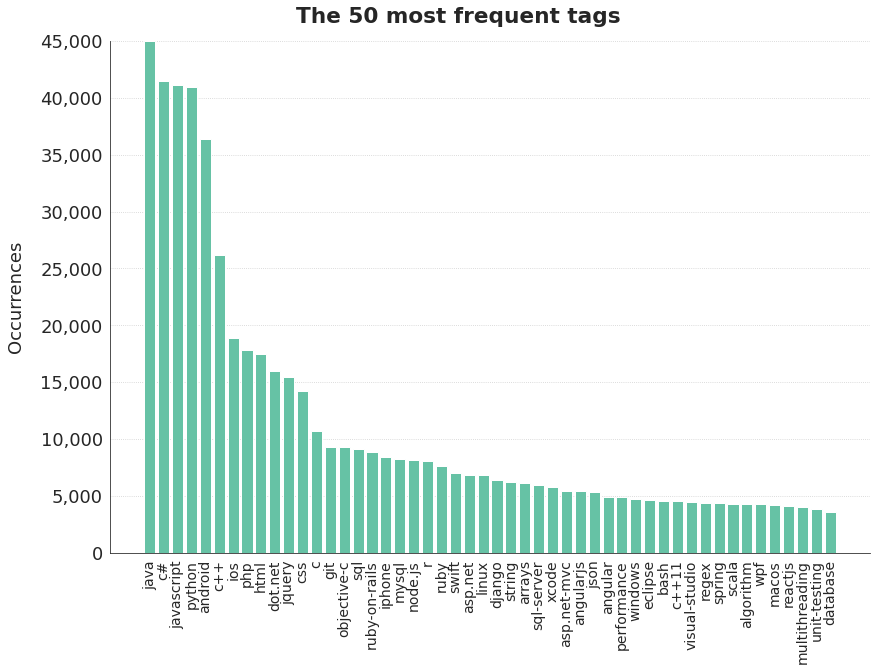

In [ ]:
graph = sfg.MyGraph("The 50 most frequent tags")
graph.add_barv(data_graph[:50].index, data_graph[:50])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Occurrences", tick_max=45000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
plt.show()

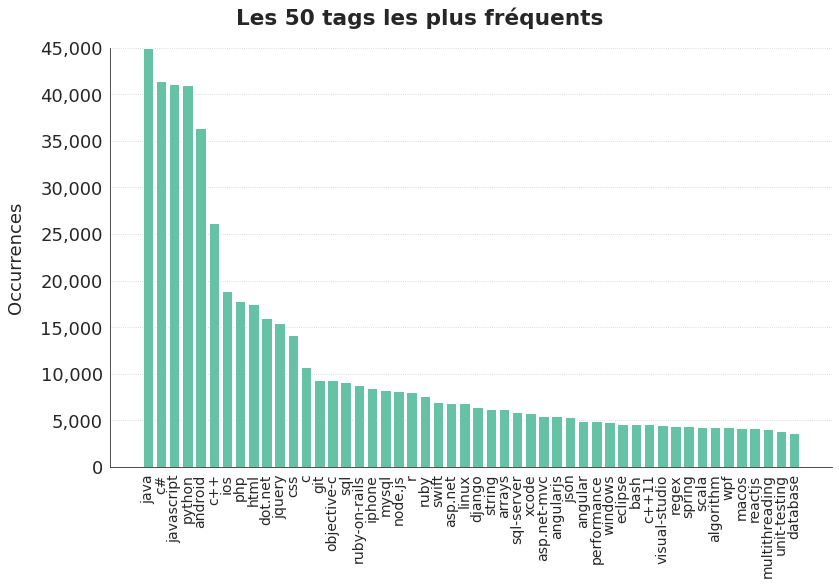

In [ ]:
graph = sfg.MyGraph("Les 50 tags les plus fréquents")
graph.add_barv(data_graph[:50].index, data_graph[:50])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Occurrences", tick_max=45000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
save_fig("ml05_01_tags_les_plus_fréquents")
plt.show()

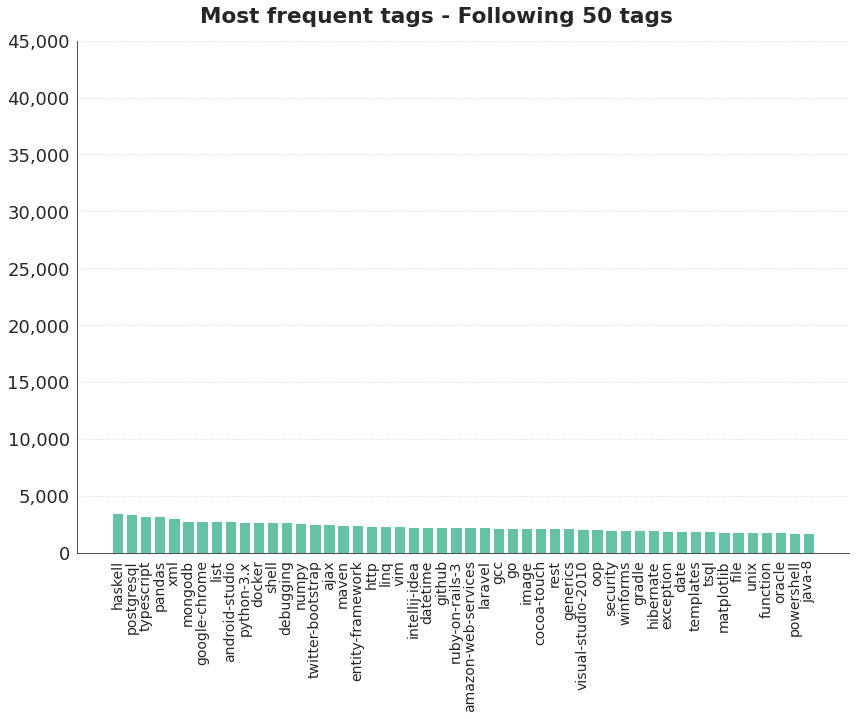

In [ ]:
graph = sfg.MyGraph("Most frequent tags - Following 50 tags")
graph.add_barv(data_graph[50:100].index, data_graph[50:100])
graph.set_axe_x(rotation=90)
graph.set_axe_y(tick_max=45000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
plt.show()

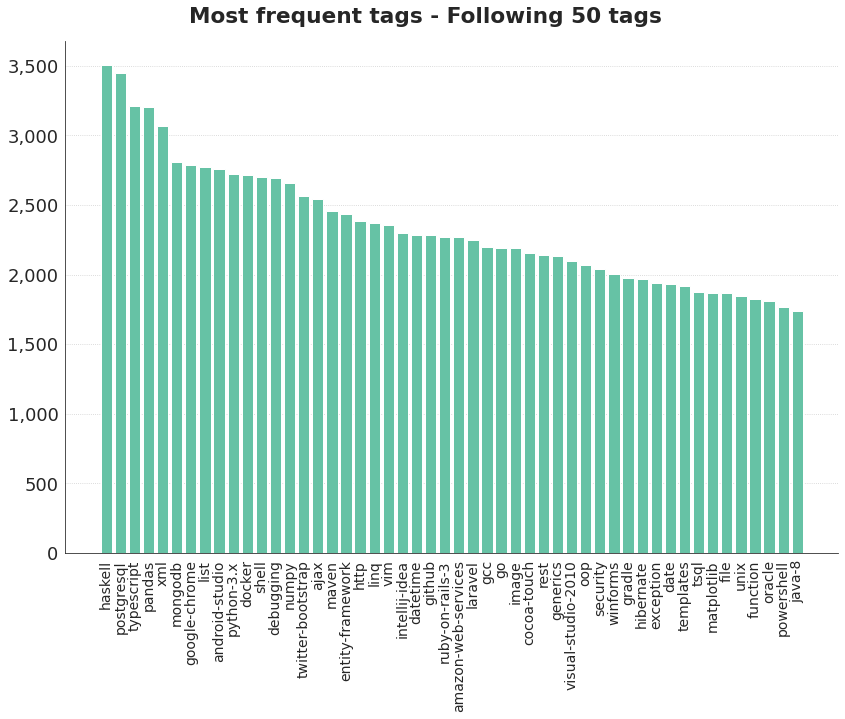

In [ ]:
graph = sfg.MyGraph("Most frequent tags - Following 50 tags")
graph.add_barv(data_graph[50:100].index, data_graph[50:100])
graph.set_axe_x(rotation=90)
graph.set_axe_y(tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
plt.show()

We need to limit the number of tags to analyse. The 100 first tags seem interesting. But only the 35 first appear in at least 1% of the questions (5000 questions). So I limit my analysis to the top 50 tags.

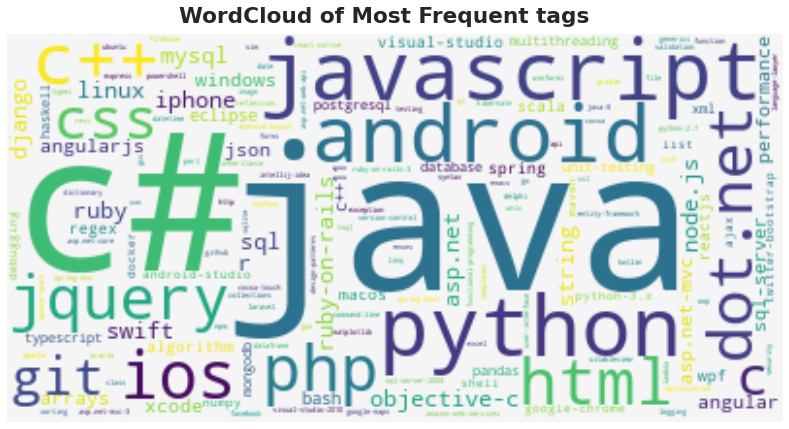

In [ ]:
graph = sfg.MyGraph("WordCloud of Most Frequent tags", y_title=0.90)
fig, ax = graph.fig, graph.ax
wc = WordCloud(relative_scaling=0.33,
               background_color="whitesmoke",
               contour_color="lightgrey").generate_from_frequencies(freq_tags)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

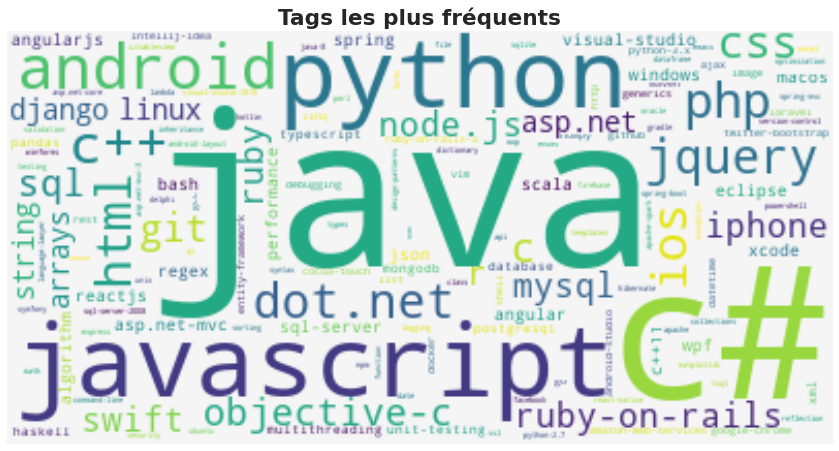

In [ ]:
graph = sfg.MyGraph("Tags les plus fréquents", y_title=0.90)
fig, ax = graph.fig, graph.ax
wc = WordCloud(relative_scaling=0.33,
               background_color="whitesmoke",
               contour_color="lightgrey").generate_from_frequencies(freq_tags)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
save_fig("ml05_01_wordcloud_tags")
plt.show()

<a id="2_2"></a>

### 2.2. Body of questions

#### 2.2.2. Number of characters in the body

How many caracters are there in the body of a question ?

In [ ]:
body_length = [len(b) for b in data.Body]

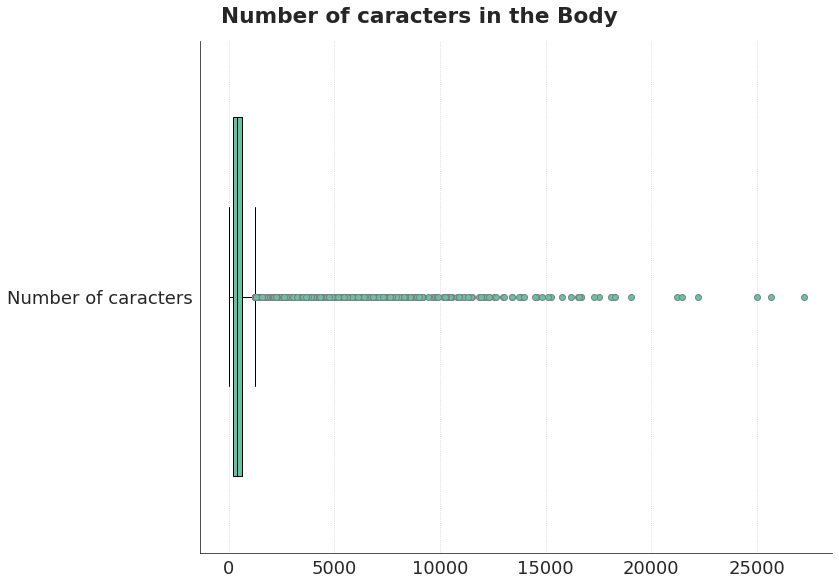

In [ ]:
graph = sfg.MyGraph("Number of caracters in the Body")
graph.add_boxplot(body_length, cat_labels=["Number of caracters"], vertical=False)
fig, ax = graph.fig, graph.ax
plt.show()

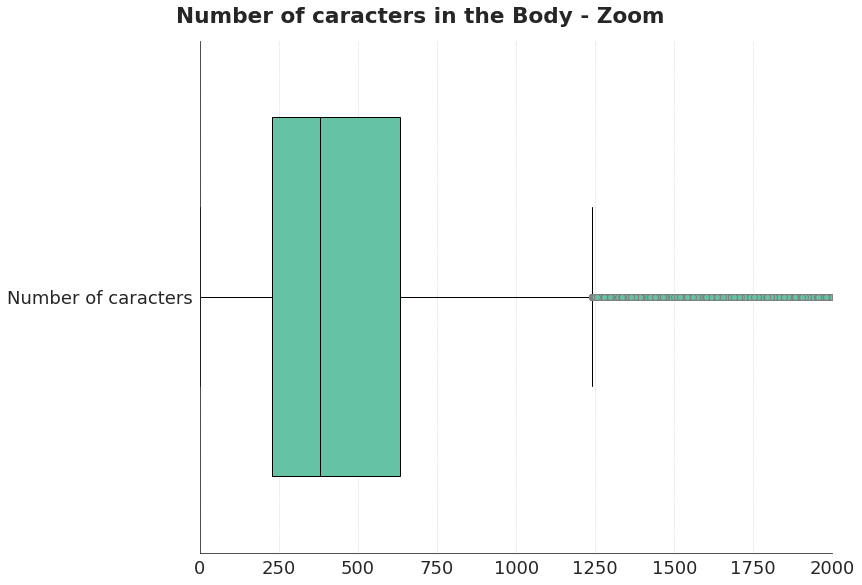

In [ ]:
graph = sfg.MyGraph("Number of caracters in the Body - Zoom")
graph.add_boxplot(body_length, cat_labels=["Number of caracters"], vertical=False)
graph.set_axe_x(tick_min=0, tick_max=2000)
fig, ax = graph.fig, graph.ax
plt.show()

The vast majority of questions have less than 1000 caracters.  

#### 2.2.3. Most frequent words in the body

To calculate words frequency, I use :
- a custom token_pattern with a regex checking :
  - the word is not made of only digits,
  - the word begins with an alphanumeric caracter,
  - the word can include alphanumeric caracters as well as + or #.
- a custom stop words list (addition of nltk and sklearn english stop words lists, without the duplicate values)

My analysis focuses on words that appear in at least 0.1% of documents, to skip the very rare words.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
print(len(nltk.corpus.stopwords.words("english")))
print(nltk.corpus.stopwords.words("english"))

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [ ]:
print(len(stop_words.ENGLISH_STOP_WORDS))
print(stop_words.ENGLISH_STOP_WORDS)

318
frozenset({'of', 'was', 'see', 'sometime', 'which', 'alone', 'seem', 'anywhere', 'a', 'nowhere', 'an', 'describe', 'one', 'others', 'thru', 'him', 'may', 'back', 'you', 'since', 'beforehand', 'con', 'ourselves', 'empty', 'two', 'but', 'below', 'still', 'whence', 'do', 'enough', 'thin', 'whereby', 'she', 'again', 'both', 'would', 'during', 'along', 'full', 'here', 'itself', 'third', 'towards', 'had', 'around', 'get', 'ours', 'only', 'elsewhere', 'latter', 'ltd', 'out', 'themselves', 'without', 'bill', 'he', 'hundred', 'down', 'often', 'fire', 'might', 'rather', 'please', 'becomes', 'well', 'who', 'via', 'her', 'above', 'few', 'keep', 'onto', 'through', 'most', 'nine', 'wherever', 'myself', 'found', 'against', 'find', 'whether', 'wherein', 'detail', 'last', 'serious', 'fill', 'how', 'less', 'became', 'done', 'next', 'each', 'whereupon', 'per', 'thus', 'hers', 'four', 'these', 'thence', 'they', 'together', 'else', 'it', 'we', 'hereupon', 'former', 'ten', 'cant', 'such', 'afterwards', 

The two lists of stopwords are complementary. I merge them to get a better stop words list.

In [ ]:
full_stop_words = nltk.corpus.stopwords.words("english") + list(set(stop_words.ENGLISH_STOP_WORDS) - set(nltk.corpus.stopwords.words("english")))
print(len(full_stop_words))
print(full_stop_words)

378
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [ ]:
vectorizer = CountVectorizer(token_pattern="(?!\d+)\w+[\w\+\#]*", stop_words=full_stop_words, min_df=0.001)
vect_body = vectorizer.fit_transform(data.Body)

In [ ]:
freqw = vect_body.sum(axis=0)
frequent_words = pd.Series(freqw.tolist()[0], index=vectorizer.get_feature_names())
frequent_words.sort_values(ascending=False)

like         225481
using        212651
code         190719
use          174824
want         153115
              ...  
relate          523
hood            522
firstly         518
apologies       508
elaborate       505
Length: 3486, dtype: int64

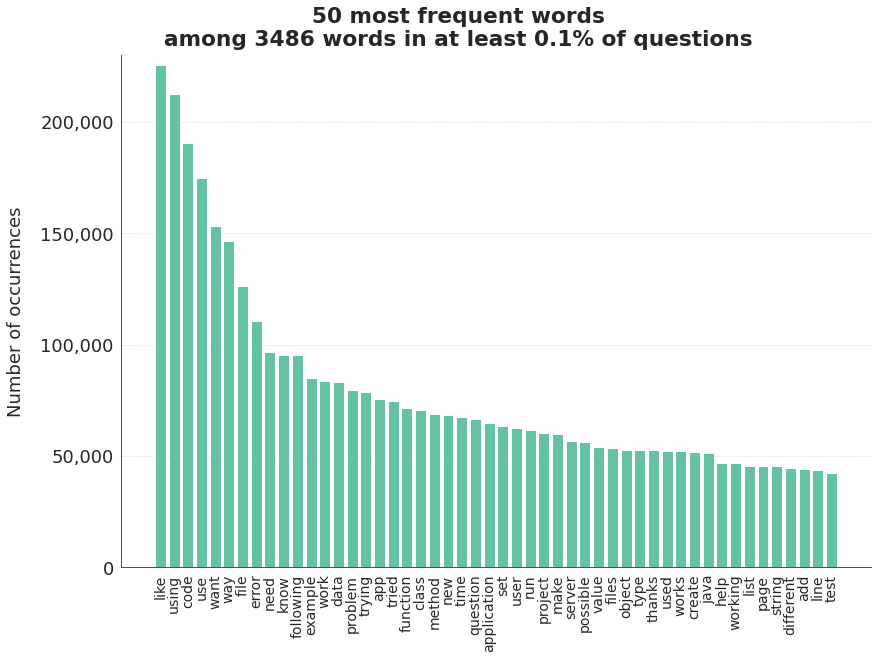

In [ ]:
graph = sfg.MyGraph("50 most frequent words\namong 3486 words in at least 0.1% of questions", y_title=1.05)
graph.add_barv(frequent_words.sort_values(ascending=False)[:50].index, frequent_words.sort_values(ascending=False)[:50])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Number of occurrences", tick_max=230000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
plt.show()

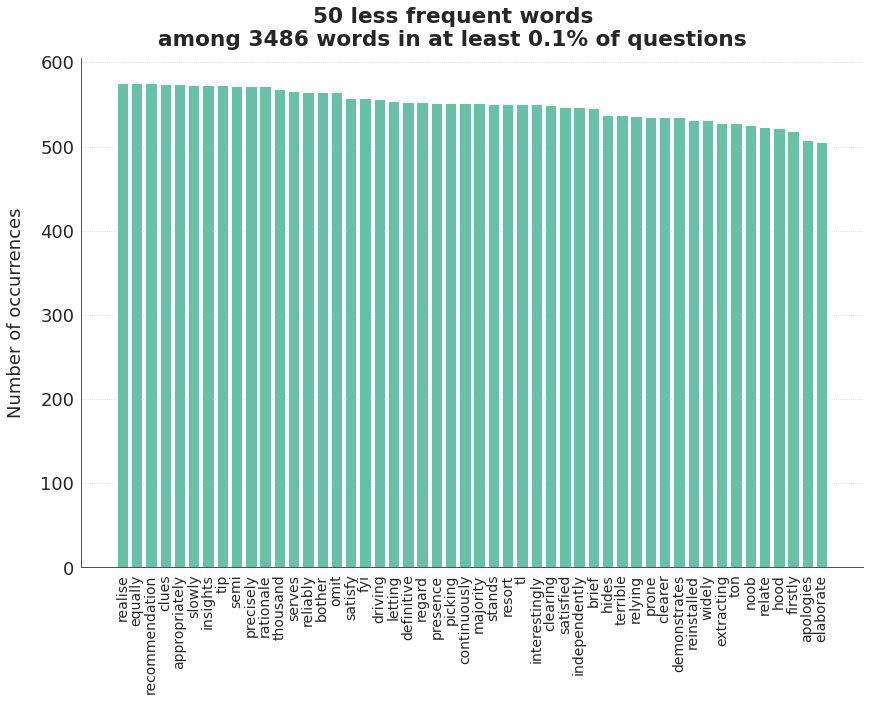

In [ ]:
graph = sfg.MyGraph("50 less frequent words\namong 3486 words in at least 0.1% of questions", y_title=1.05)
graph.add_barv(frequent_words.sort_values(ascending=False)[-50:].index, frequent_words.sort_values(ascending=False)[-50:])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Number of occurrences", tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
plt.show()

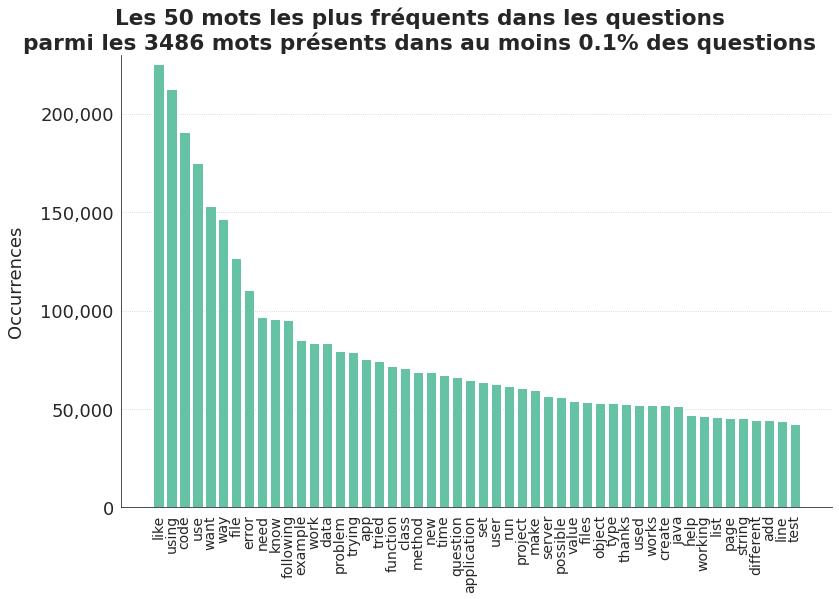

In [ ]:
graph = sfg.MyGraph("Les 50 mots les plus fréquents dans les questions\nparmi les 3486 mots présents dans au moins 0.1% des questions",
                    y_title=1.05)
graph.add_barv(frequent_words.sort_values(ascending=False)[:50].index,
               frequent_words.sort_values(ascending=False)[:50])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Occurrences", tick_max=230000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
save_fig("ml05_01_most_frequent_words_questions")
plt.show()

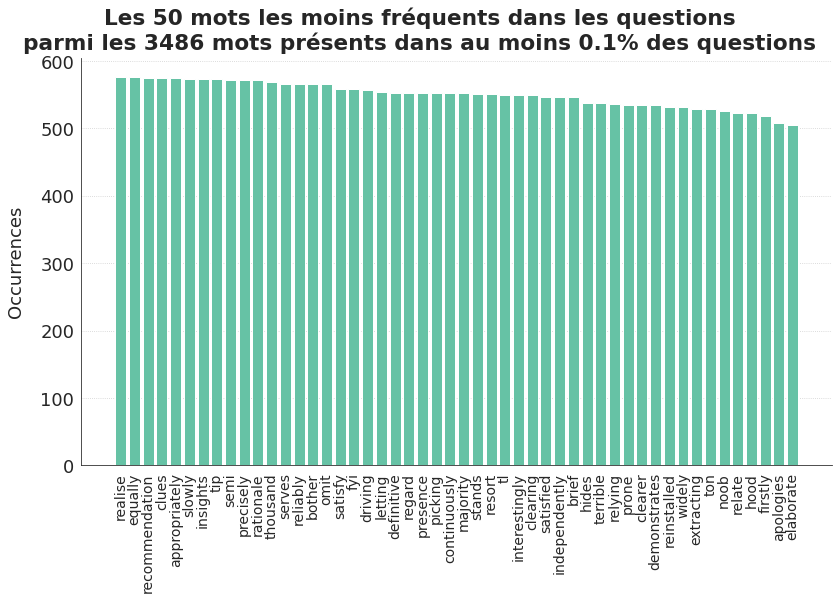

In [ ]:
graph = sfg.MyGraph("Les 50 mots les moins fréquents dans les questions\nparmi les 3486 mots présents dans au moins 0.1% des questions",
                    y_title=1.05)
graph.add_barv(frequent_words.sort_values(ascending=False)[-50:].index,
               frequent_words.sort_values(ascending=False)[-50:])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Occurrences", tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
save_fig("ml05_01_less_frequent_words_questions")
plt.show()

Less frequent words don't seem to be very usefull to find different topics. Some words in the most frequent ones seem to be more efficient for that goal.

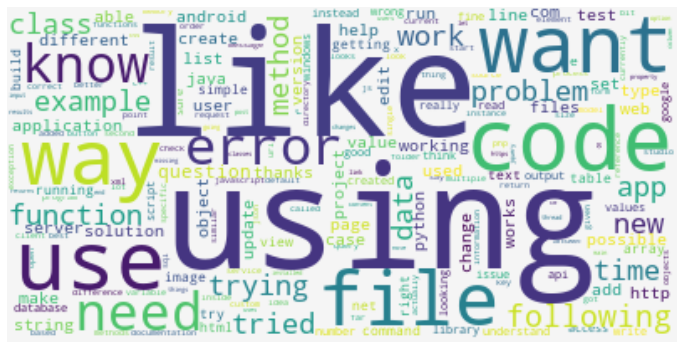

In [ ]:
wc = WordCloud(relative_scaling=0.33,
               background_color="whitesmoke",
               contour_color="lightgrey")\
               .generate_from_frequencies(frequent_words.to_dict())
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

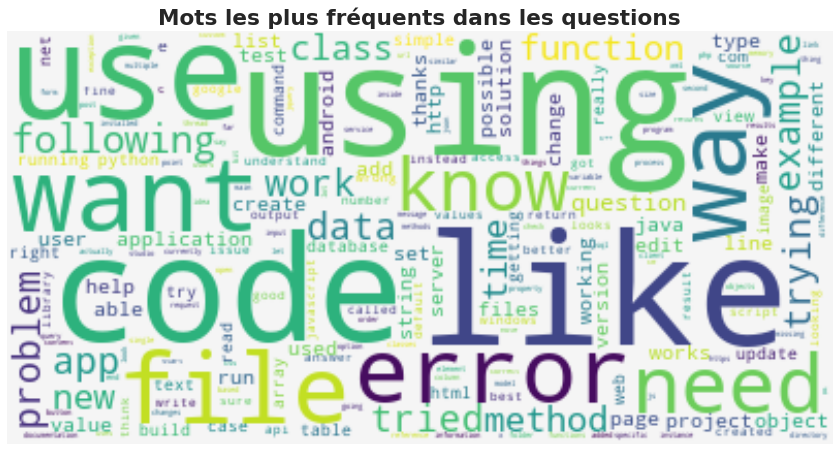

In [ ]:
graph = sfg.MyGraph("Mots les plus fréquents dans les questions", y_title=0.90)
fig, ax = graph.fig, graph.ax
wc = WordCloud(relative_scaling=0.33,
               background_color="whitesmoke",
               contour_color="lightgrey")\
               .generate_from_frequencies(frequent_words.to_dict())
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
save_fig("ml05_01_wordcloud_questions")
plt.show()

#### 2.2.4. Number of words in the body

I don't use stop words and I check all words (no min_df) to calculate the number of words by document.

In [ ]:
vectorizer = CountVectorizer(token_pattern="(?!\d+)\w+[\w\+\#]*")
vect_body = vectorizer.fit_transform(data.Body)

In [ ]:
freqw = vect_body.sum(axis=1)
number_of_words = pd.Series(freqw.reshape(-1).tolist()[0], index=data.index)
number_of_words.sort_values(ascending=False)

Id
4003286     3926
3960305     3304
547278      3253
52480925    3225
14437096    3167
            ... 
55299138       0
49880928       0
2746677        0
47446681       0
42944775       0
Length: 500000, dtype: int64

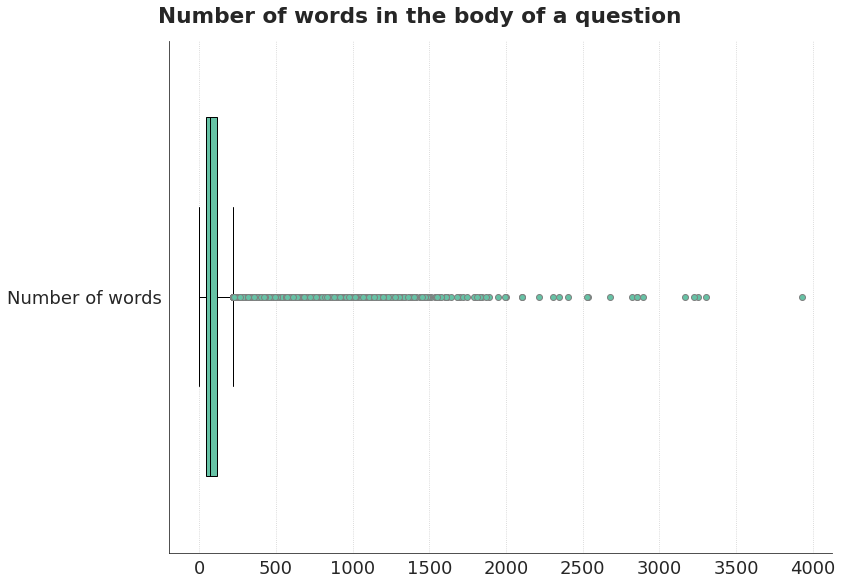

In [ ]:
graph = sfg.MyGraph("Number of words in the body of a question")
graph.add_boxplot(number_of_words, cat_labels=["Number of words"], vertical=False)
fig, ax = graph.fig, graph.ax
plt.show()

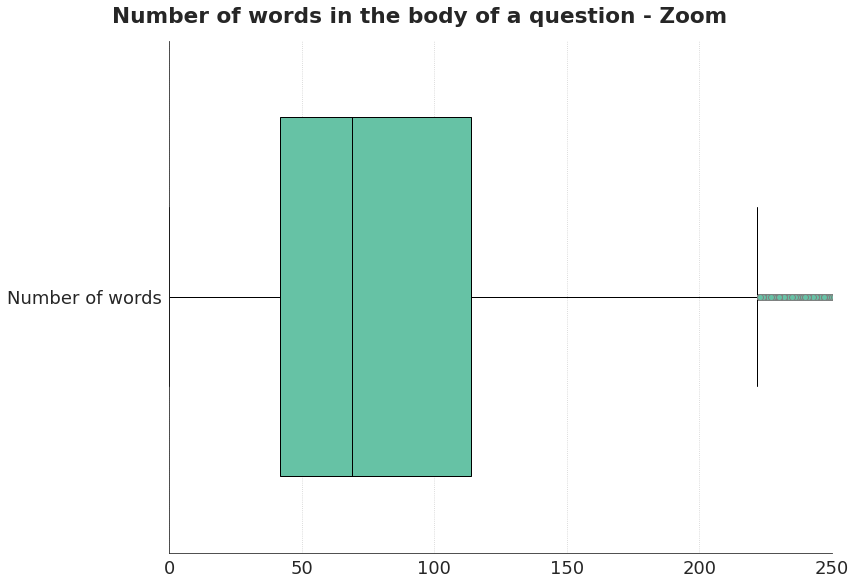

In [ ]:
graph = sfg.MyGraph("Number of words in the body of a question - Zoom")
graph.add_boxplot(number_of_words, cat_labels=["Number of words"], vertical=False)
graph.set_axe_x(tick_min=0, tick_max=250)
fig, ax = graph.fig, graph.ax
plt.show()

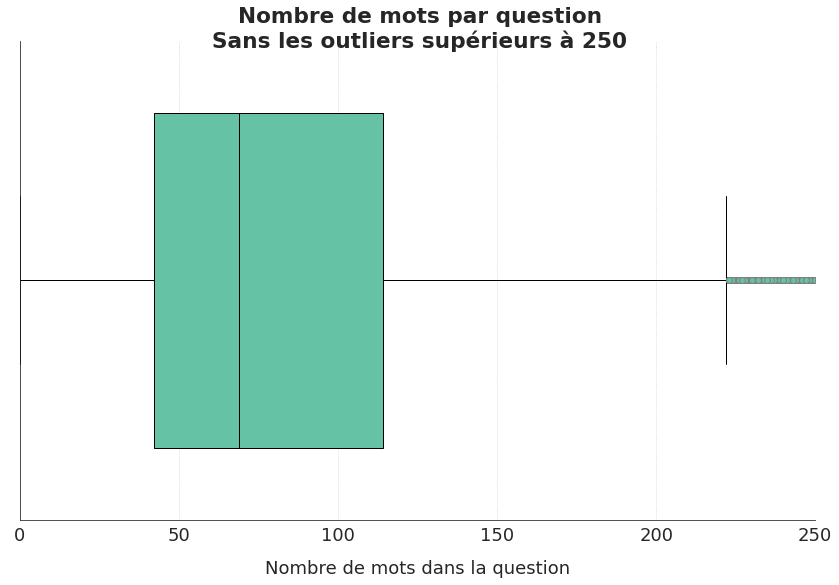

In [ ]:
graph = sfg.MyGraph("Nombre de mots par question\nSans les outliers supérieurs à 250")
graph.add_boxplot(number_of_words, cat_labels=[" "], vertical=False)
graph.set_axe_x(label="Nombre de mots dans la question", tick_min=0, tick_max=250)
fig, ax = graph.fig, graph.ax
save_fig("ml05_01_number_words_questions")
plt.show()

I look at the questions whitout words.

In [ ]:
data.loc[number_of_words[number_of_words==0].index]

,Body,Title,Tags
Id,,,
3755606,,What does the exclamation mark do before the f...,"[javascript, function]"
949433,,Why are these constructs using pre and post-in...,"[c, increment, undefined-behavior, operator-pr..."
14654718,... ... ... ?,How to use ADB Shell when Multiple Devices are...,"[android, shell, cmd, adb, android-debug]"
24611640,,curl: (60) SSL certificate problem: unable to ...,"[curl, ssl, openssl, ssl-certificate, x509cert..."
1979004,,What is the difference between isinstance('aaa...,"[python, python-2.x, built-in-types]"
...,...,...,...
48039119,,com.android.builder.testing.api.DeviceExceptio...,"[react-native, ubuntu-16.04, react-native-andr..."
12637779,,how to convert const WCHAR * to const char *,[c++]
1978264,,what does '__getnewargs__' do in this code,[python]


101 rows have a title but no body. I delete them.

In [ ]:
data.drop(number_of_words[number_of_words==0].index, inplace=True)

In [ ]:
number_of_words.describe()

count    500000.000000
mean         93.220808
std          88.001394
min           0.000000
25%          42.000000
50%          69.000000
75%         114.000000
max        3926.000000
dtype: float64

I now look at the number of unique words in the body.

In [ ]:
vectorizer = CountVectorizer(token_pattern="(?!\d+)\w+[\w\+\#]*", binary=True)
vect_body = vectorizer.fit_transform(data.Body)
freqw = vect_body.sum(axis=1)
number_of_unique_words = pd.Series(freqw.reshape(-1).tolist()[0], index=data.index)
number_of_unique_words.sort_values(ascending=False)

Id
4292535     780
28862767    753
14458896    710
547278      710
14333593    708
           ... 
2361789       1
1685277       1
46045834      1
16951267      1
832           1
Length: 499899, dtype: int64

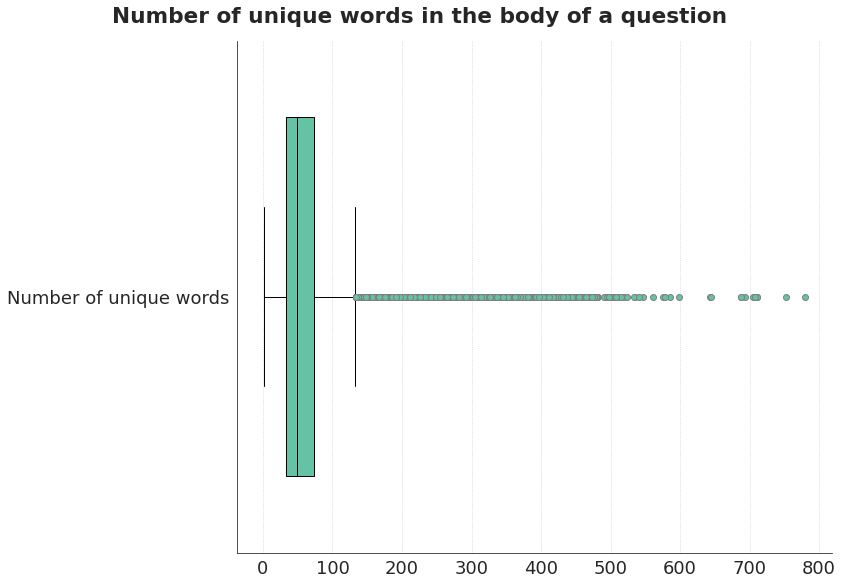

In [ ]:
graph = sfg.MyGraph("Number of unique words in the body of a question")
graph.add_boxplot(number_of_unique_words, cat_labels=["Number of unique words"], vertical=False)
fig, ax = graph.fig, graph.ax
plt.show()

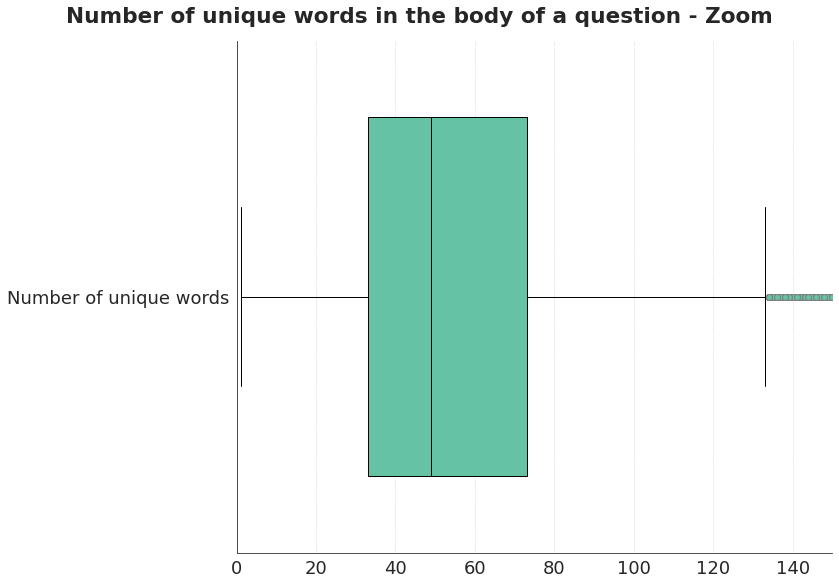

In [ ]:
graph = sfg.MyGraph("Number of unique words in the body of a question - Zoom")
graph.add_boxplot(number_of_unique_words, cat_labels=["Number of unique words"], vertical=False)
graph.set_axe_x(tick_min=0, tick_max=150)
fig, ax = graph.fig, graph.ax
plt.show()

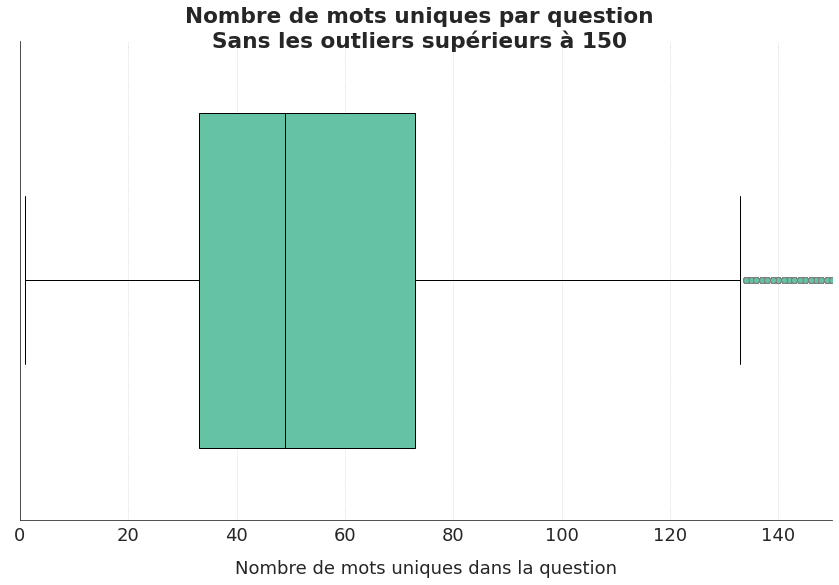

In [ ]:
graph = sfg.MyGraph("Nombre de mots uniques par question\nSans les outliers supérieurs à 150")
graph.add_boxplot(number_of_unique_words, cat_labels=[" "], vertical=False)
graph.set_axe_x(label="Nombre de mots uniques dans la question", tick_min=0, tick_max=150)
fig, ax = graph.fig, graph.ax
save_fig("ml05_01_number_unique_words_questions")
plt.show()

In [ ]:
number_of_unique_words.describe()

count    499899.000000
mean         58.239236
std          38.843302
min           1.000000
25%          33.000000
50%          49.000000
75%          73.000000
max         780.000000
dtype: float64

<a id="2_3"></a>

### 2.3. Title of questions

My analysis has shown that some titles are empty. I check that.

In [ ]:
data[data.Title.isna()]

,Body,Title,Tags
Id,,,
310914,The examples have very different outcomes. Bef...,NaN,[javascript]


There's only one line without Title. I replace Title by a space caracter.

In [ ]:
def prepare_title(df):
  index_to_change = df[df.Title.isna()].index
  for idx in index_to_change:
    df.loc[idx, "Title"] = " "
  return df 

In [ ]:
data = prepare_title(data)

#### 2.3.1. Number od characters in the title

How many caracters are there in the body of a question ?

In [ ]:
title_length = [len(t) for t in data.Title]

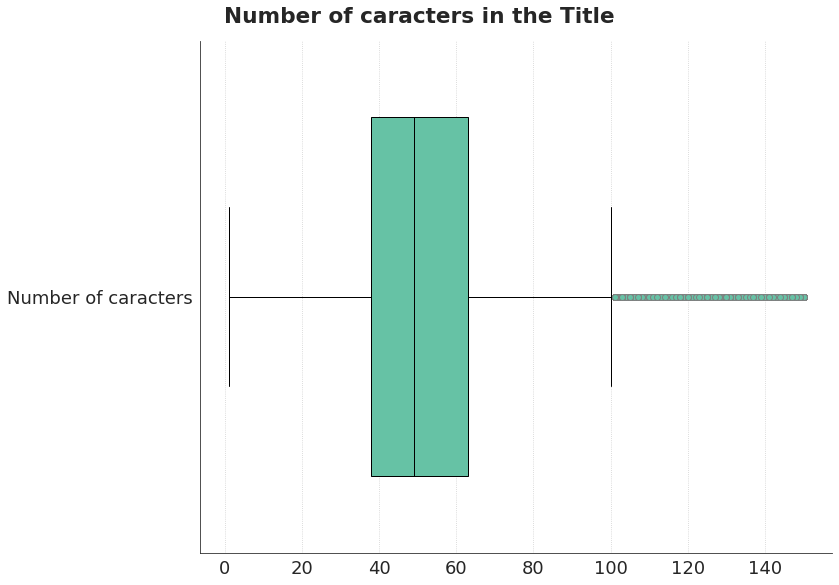

In [ ]:
graph = sfg.MyGraph("Number of caracters in the Title")
graph.add_boxplot(title_length, cat_labels=["Number of caracters"], vertical=False)
fig, ax = graph.fig, graph.ax
plt.show()

Allmost all titles have less than 100 caracters.  

#### 2.3.2. Most frequent words in the title

To calculate words frequency, I use :
- a custom token_pattern with a regex checking :
  - the word is not made of only digits,
  - the word begins with an alphanumeric caracter,
  - the word can include alphanumeric caracters as well as + or #.
- a custom stop words list (addition of nltk and sklearn english stop words lists, without the duplicate values)

My analysis focuses on words that appear in at least 1% of documents.

In [ ]:
vectorizer = CountVectorizer(token_pattern="(?!\d+)\w+[\w\+\#]*", stop_words=full_stop_words, min_df=0.001)
vect_title = vectorizer.fit_transform(data.Title)

In [ ]:
freqw = vect_title.sum(axis=0)
frequent_words = pd.Series(freqw.tolist()[0], index=vectorizer.get_feature_names())
frequent_words.sort_values(ascending=False)

using      30025
android    19797
file       19756
use        19033
python     17211
           ...  
gui          508
learn        508
pre          507
throws       504
extra        501
Length: 964, dtype: int64

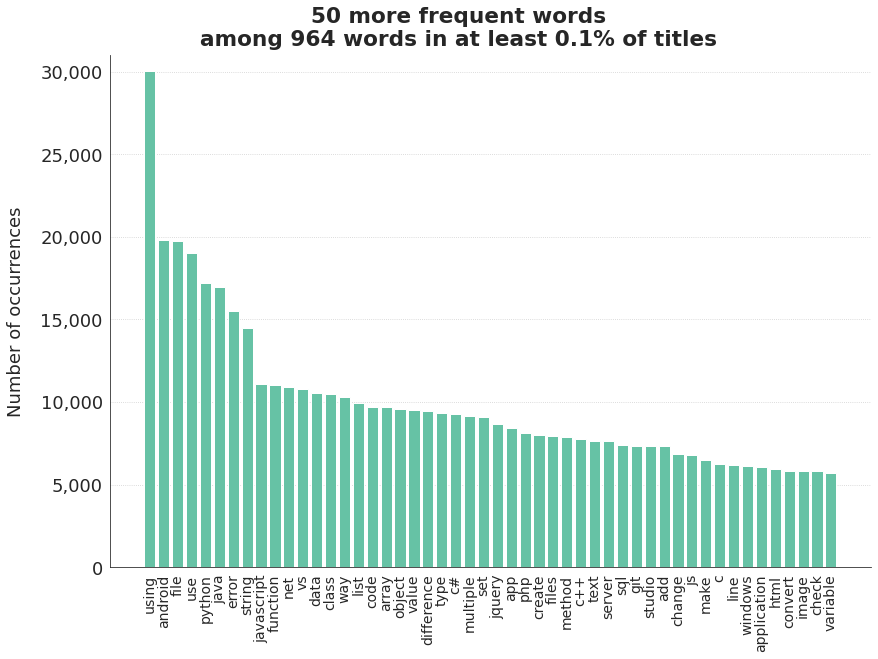

In [ ]:
graph = sfg.MyGraph("50 more frequent words\namong 964 words in at least 0.1% of titles", y_title=1.05)
graph.add_barv(frequent_words.sort_values(ascending=False)[:50].index,
               frequent_words.sort_values(ascending=False)[:50])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Number of occurrences", tick_max=31000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
plt.show()

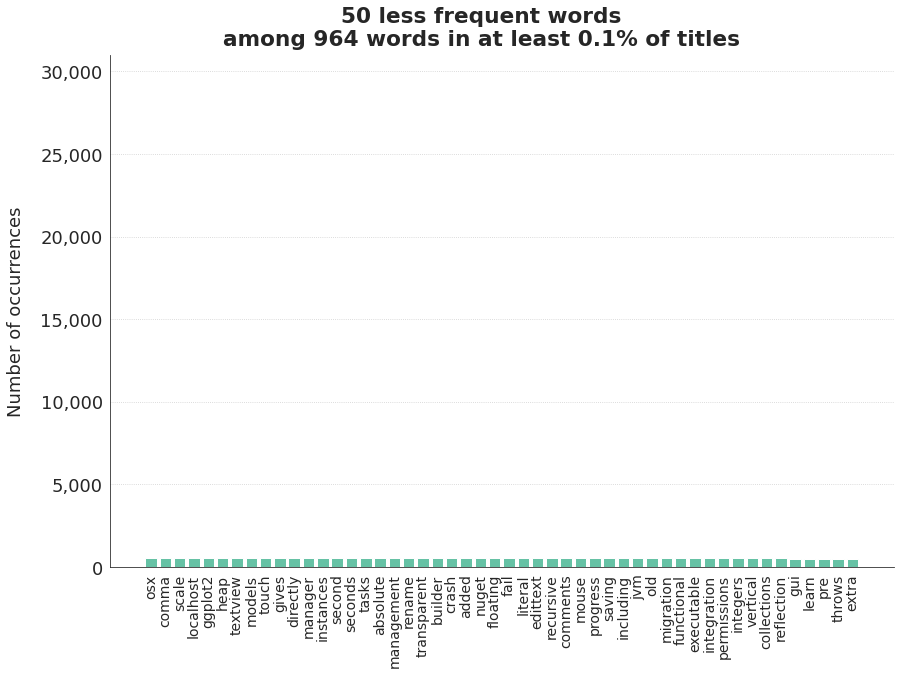

In [ ]:
graph = sfg.MyGraph("50 less frequent words\namong 964 words in at least 0.1% of titles", y_title=1.05)
graph.add_barv(frequent_words.sort_values(ascending=False)[-50:].index,
               frequent_words.sort_values(ascending=False)[-50:])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Number of occurrences", tick_max=31000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
plt.show()

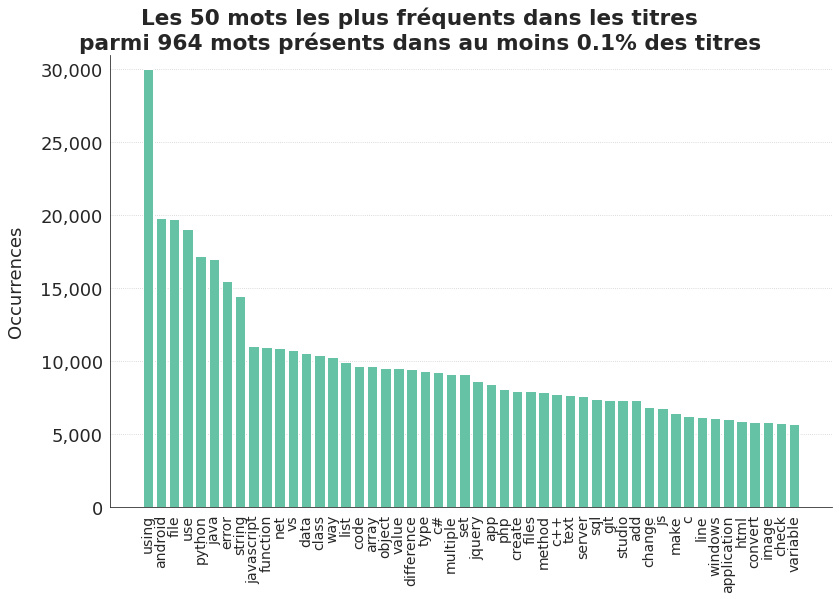

In [ ]:
graph = sfg.MyGraph("Les 50 mots les plus fréquents dans les titres\nparmi 964 mots présents dans au moins 0.1% des titres",
                    y_title=1.05)
graph.add_barv(frequent_words.sort_values(ascending=False)[:50].index,
               frequent_words.sort_values(ascending=False)[:50])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Occurrences", tick_max=31000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
save_fig("ml05_01_most_frequent_words_titles")
plt.show()

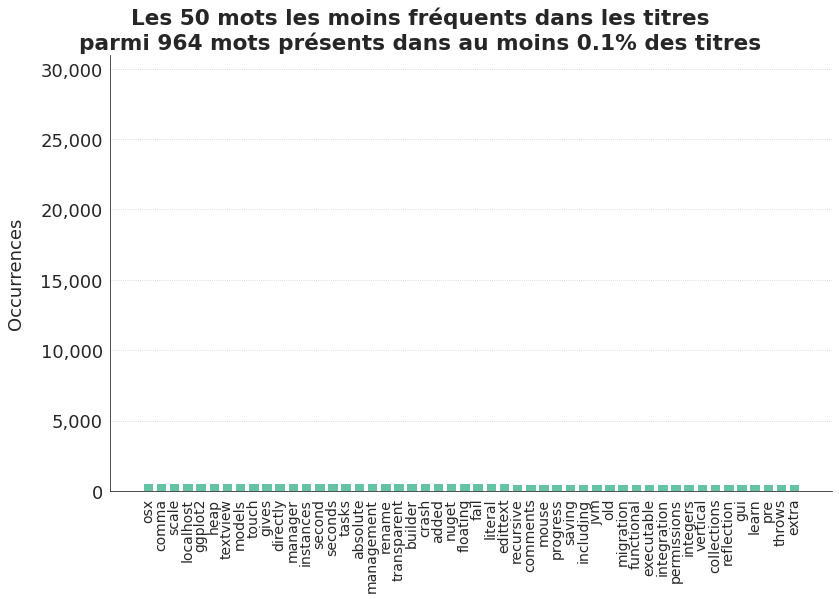

In [ ]:
graph = sfg.MyGraph("Les 50 mots les moins fréquents dans les titres\nparmi 964 mots présents dans au moins 0.1% des titres",
                    y_title=1.05)
graph.add_barv(frequent_words.sort_values(ascending=False)[-50:].index,
               frequent_words.sort_values(ascending=False)[-50:])
graph.set_axe_x(rotation=90)
graph.set_axe_y(label="Occurrences", tick_max=31000, tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
ax[0].tick_params(axis='x', labelsize=14)
save_fig("ml05_01_less_frequent_words_titles")
plt.show()

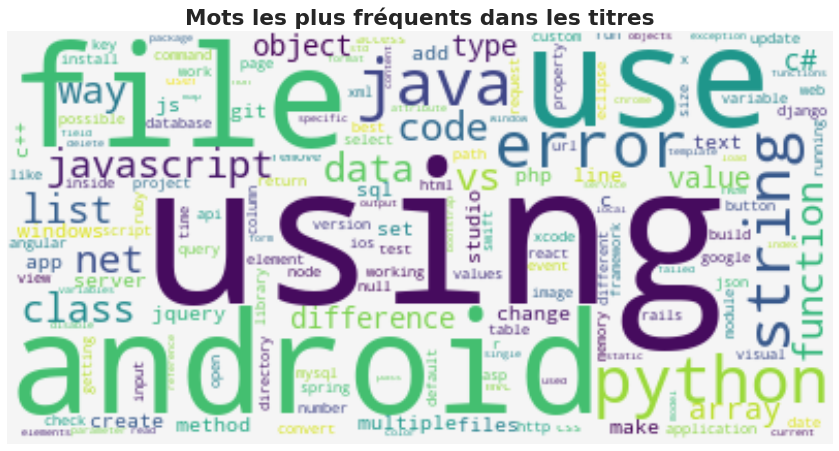

In [ ]:
graph = sfg.MyGraph("Mots les plus fréquents dans les titres", y_title=0.90)
wc = WordCloud(relative_scaling=0.33,
               background_color="whitesmoke",
               contour_color="lightgrey")\
               .generate_from_frequencies(frequent_words.to_dict())
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
save_fig("ml05_01_wordcloud_titles")
plt.show()

#### 2.3.3. Number of words in the title

I don't use stop words and I check all words (no min_df) to calculate the number of words by title.

In [ ]:
vectorizer = CountVectorizer(token_pattern="(?!\d+)\w+[\w\+\#]*")
vect_body = vectorizer.fit_transform(data.Title)

In [ ]:
freqw = vect_body.sum(axis=1)
number_of_words = pd.Series(freqw.reshape(-1).tolist()[0], index=data.index)
number_of_words.sort_values(ascending=False)

Id
18496282    31
7861648     31
5769568     30
6508203     30
3815116     30
            ..
2051385      1
25900906     1
3929544      1
173070       0
310914       0
Length: 499899, dtype: int64

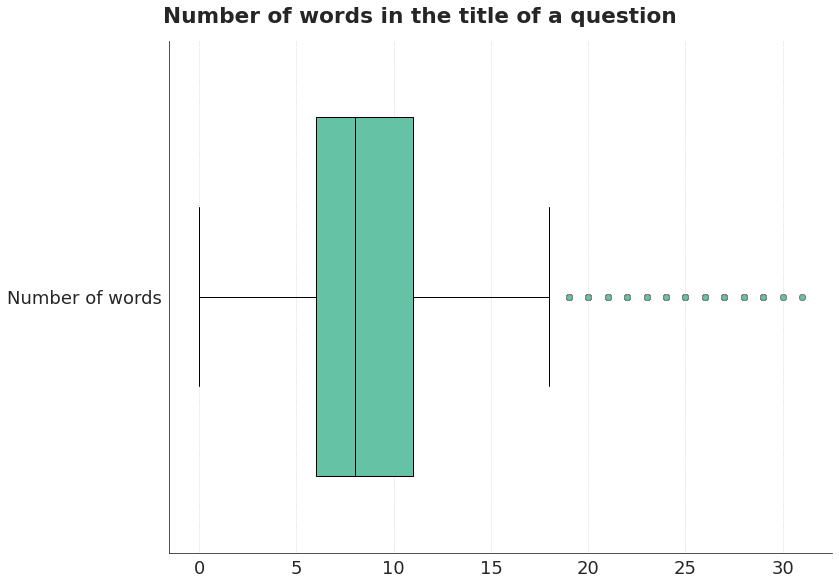

In [ ]:
graph = sfg.MyGraph("Number of words in the title of a question")
graph.add_boxplot(number_of_words, cat_labels=["Number of words"], vertical=False)
fig, ax = graph.fig, graph.ax
plt.show()

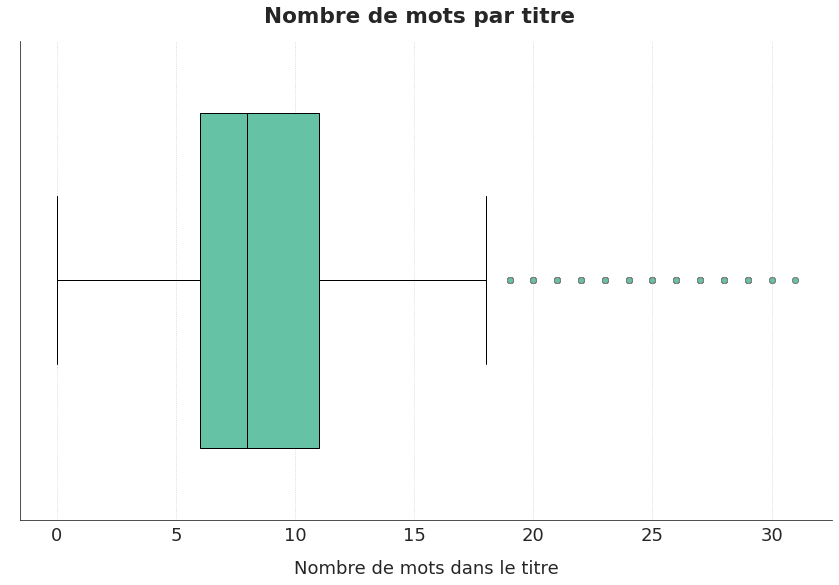

In [ ]:
graph = sfg.MyGraph("Nombre de mots par titre")
graph.add_boxplot(number_of_words, cat_labels=[" "], vertical=False)
graph.set_axe_x(label="Nombre de mots dans le titre")
fig, ax = graph.fig, graph.ax
save_fig("ml05_01_nb_mots_titre")
plt.show()

I look at the titles whitout words.

In [ ]:
data.loc[number_of_words[number_of_words==0].index]

,Body,Title,Tags
Id,,,
310914,The examples have very different outcomes. Bef...,,[javascript]
173070,I heard that you could right-shift a number by...,2.9999999999999999 >> .5?,"[javascript, bit-manipulation, precision]"


2 rows have a title without words. I delete them from the database.

In [ ]:
data.drop(number_of_words[number_of_words==0].index, inplace=True)

I now look at the number of unique words in the title.

In [ ]:
vectorizer = CountVectorizer(token_pattern="(?!\d+)\w+[\w\+\#]*", binary=True)
vect_body = vectorizer.fit_transform(data.Title)
freqw = vect_body.sum(axis=1)
number_of_unique_words = pd.Series(freqw.reshape(-1).tolist()[0], index=data.index)
number_of_unique_words.sort_values(ascending=False)

Id
29703386    28
3304157     27
57377518    27
32418206    26
7861648     26
            ..
5693312      1
7716562      1
292797       1
4121450      1
15570041     1
Length: 499897, dtype: int64

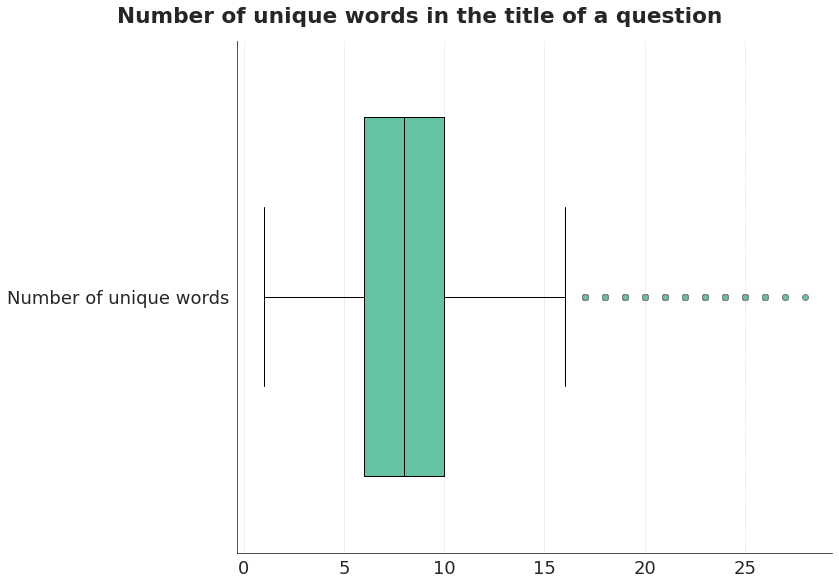

In [ ]:
graph = sfg.MyGraph("Number of unique words in the title of a question")
graph.add_boxplot(number_of_unique_words, cat_labels=["Number of unique words"], vertical=False)
fig, ax = graph.fig, graph.ax
plt.show()

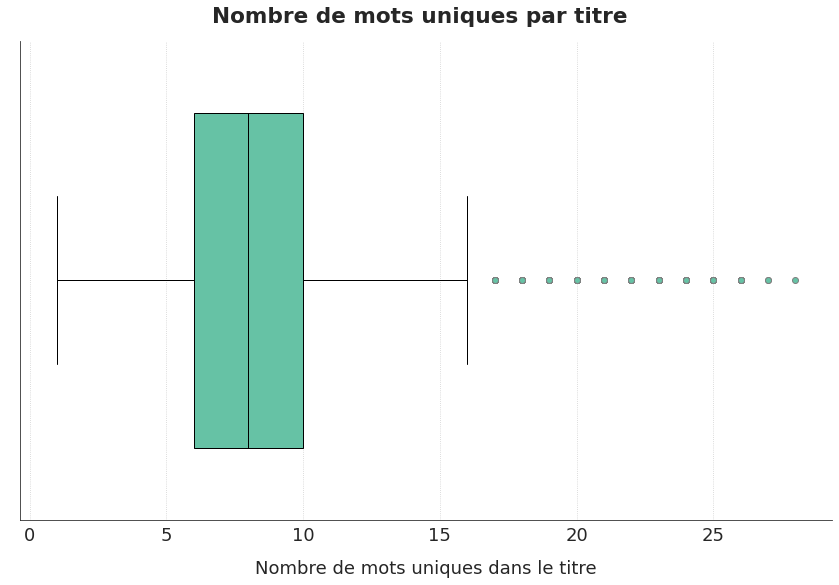

In [ ]:
graph = sfg.MyGraph("Nombre de mots uniques par titre")
graph.add_boxplot(number_of_unique_words, cat_labels=[" "], vertical=False)
graph.set_axe_x(label="Nombre de mots uniques dans le titre")
fig, ax = graph.fig, graph.ax
save_fig("ml05_01_nb_mots_uniques_titre")
plt.show()

---
<a id='3_0'></a>

## <font color=blue>3. Data preparation</font>

### 3.1. Preparation of the multi-label targets

I delete the questions that are not related to one the top 50 tags.

In [ ]:
tags_to_keep = list(pd.Series(freq_tags).sort_values(ascending=False).iloc[:50].index)
print(tags_to_keep[:10])

['java', 'c#', 'javascript', 'python', 'android', 'c++', 'ios', 'php', 'html', 'dot.net']


In [ ]:
mlb = MultiLabelBinarizer(classes=tags_to_keep)
label_tags = pd.DataFrame(mlb.fit_transform(data.Tags), index=data.index, columns=tags_to_keep)
label_tags.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['a-records', 'a-star', 'a0poster', 'a2dp', 'aabb', 'aac', 'aadhaar', 'aapt', 'aapt2', 'aar', 'aasm', 'ab-testing', 'abac', 'abaddressbook', 'abaddressbooksource', 'abandoned-memory', 'abandonedmutexexception', 'abap', 'abbr', 'abbreviation', 'abc', 'abcl', 'abcpdf', 'abi', 'ableton-live', 'ably-realtime', 'abort', 'about-box', 'abpeoplepickerview', 'abpersonviewcontroller', 'abrecord', 'abrecordcopyvalue', 'abrecordref', 'absinthe', 'absl-py', 'absolute', 'absolute-path', 'absolute-value', 'absolutelayout', 'abstract', 'abstract-algebra', 'abstract-base-class', 'abstract-class', 'abstract-data-type', 'abstract-factory', 'abstract-function', 'abstract-interpretation', 'abstract-methods', 'abstract-syntax-tree', 'abstract-type', 'abstraction', 'abstractmethoderror', 'abstracttablemodel', 'abuse', 'acc', 'accelerate-framework', 'accelerate-haskell', 'accelerated-mobile-page', 'accel

,java,c#,javascript,python,android,c++,ios,php,html,dot.net,jquery,css,c,git,objective-c,sql,ruby-on-rails,iphone,mysql,node.js,r,ruby,swift,asp.net,linux,django,string,arrays,sql-server,xcode,asp.net-mvc,angularjs,json,angular,performance,windows,eclipse,bash,c++11,visual-studio,regex,spring,scala,algorithm,wpf,macos,reactjs,multithreading,unit-testing,database
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11227809,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
927358,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2003505,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
292357,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
231767,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
label_tags.shape

(499897, 50)

In [ ]:
label_tags["nb_tags"] = label_tags.sum(axis=1)

In [ ]:
clean_data = data.merge(label_tags, how='left',
                        left_index=True, right_index=True)
# reset_index to keep track of Id in the following steps
clean_data = clean_data[clean_data.nb_tags > 0].reset_index()
clean_data.shape

(401214, 55)

I have 401 214 questions related to one of the top 50 tags.

In [ ]:
# to free memory
data = []
label_tags = []

<a id="3_2"></a>

### 3.2. Stratified data splits

#### 3.2.1 Train and test sets

I do a stratified train-test split. I use skmultilearn to take into account the specificity due to the multi-labeling.  
I split in 80% of data for training and 20% of data for testing.

In [ ]:
# checking X
clean_data[["Id", "Body", "Title"]].head()

,Id,Body,Title
0,11227809,Here is a piece of C++ code that shows some ve...,Why is processing a sorted array faster than p...
1,927358,I accidentally committed the wrong files to Gi...,How do I undo the most recent local commits in...
2,2003505,I want to delete a branch both locally and rem...,How do I delete a Git branch locally and remot...
3,292357,What are the differences between and ?,What is the difference between 'git pull' and ...
4,231767,"What is the use of the keyword in Python, and...","What does the ""yield"" keyword do?"


In [ ]:
# checking y
clean_data[clean_data.columns[4:-1]].head()

,java,c#,javascript,python,android,c++,ios,php,html,dot.net,jquery,css,c,git,objective-c,sql,ruby-on-rails,iphone,mysql,node.js,r,ruby,swift,asp.net,linux,django,string,arrays,sql-server,xcode,asp.net-mvc,angularjs,json,angular,performance,windows,eclipse,bash,c++11,visual-studio,regex,spring,scala,algorithm,wpf,macos,reactjs,multithreading,unit-testing,database
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_fulltrain, y_fulltrain, X_test, y_test = \
    iterative_train_test_split(clean_data[["Id", "Body", "Title"]].values,
                               clean_data[clean_data.columns[4:-1]].values,
                               test_size=0.2)

In [ ]:
X_fulltrain.shape

(321430, 3)

In [ ]:
y_fulltrain.shape

(321430, 50)

In [ ]:
X_test.shape

(79784, 3)

In [ ]:
y_test.shape

(79784, 50)

In [ ]:
X_fulltrain = pd.DataFrame(X_fulltrain, columns=["id", "body", "title"])
X_test = pd.DataFrame(X_test, columns=["id", "body", "title"])
y_fulltrain = pd.DataFrame(y_fulltrain, columns=tags_to_keep)
y_test = pd.DataFrame(y_test, columns=tags_to_keep)

In [ ]:
X_fulltrain.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")
y_fulltrain.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

#### 3.2.2. Train, valid and mini sets (stratified sub-sets from the train set)

I split the train data in 80% for training and 20% for validation. I do so because cross-validation is not possible on all algortihms. For example, LDA or NMF are not suitable for cross-validation.

In [ ]:
X_train, y_train, X_valid, y_valid = \
    iterative_train_test_split(X_fulltrain.values, 
                               y_fulltrain.values, 
                               test_size=0.2)

In [ ]:
X_train = pd.DataFrame(X_train, columns=X_fulltrain.columns)
X_valid = pd.DataFrame(X_valid, columns=X_fulltrain.columns)
X_train.shape

In [ ]:
y_train = pd.DataFrame(y_train, columns=y_fulltrain.columns)
y_valid = pd.DataFrame(y_valid, columns=y_fulltrain.columns)
y_train.shape

To speed up the preliminary tests, I do a new stratified train-test split to explore LDA and determine its optimal number of topics with only 5% of my data.

In [ ]:
X_mini, y_mini, _, _ = \
    iterative_train_test_split(X_train.values, 
                               y_train.values, 
                               test_size=0.95)

In [ ]:
X_mini = pd.DataFrame(X_mini, columns=X_fulltrain.columns)
X_mini.shape

In [ ]:
y_mini = pd.DataFrame(y_mini, columns=y_fulltrain.columns)
y_mini.shape

I save data to get a fast access to the same data for the future steps of the project.

In [ ]:
X_train.to_csv("X_subtrain.csv")
y_train.to_csv("y_subtrain.csv")
X_valid.to_csv("X_subvalid.csv")
y_valid.to_csv("y_subvalid.csv")
X_mini.to_csv("X_mini.csv")
y_mini.to_csv("y_mini.csv")